In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from circadian.models import DynamicalTrajectory, Skeldon23

In [94]:
data_location = 'data/light_schedules/'
time = np.load(data_location + 'time.npy')
regular_light = np.load(data_location + 'regular_light.npy')
chang14_ebook_first_light = np.load(data_location + 'chang14_ebook_first_light.npy')
chang14_ebook_second_light = np.load(data_location + 'chang14_ebook_second_light.npy')

In [95]:
simulation_features = pd.read_csv("data/chang14_selected_sleep_parameters/selected_sleep_parameters_simulation_features.csv", index_col=0)

# Sleep pressure example plot

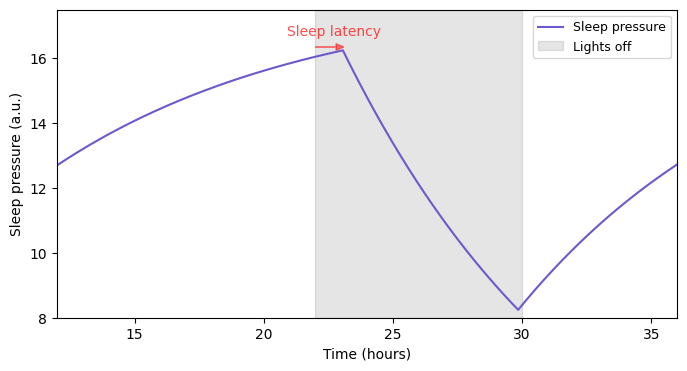

In [96]:
condition = 'chang14_ebook_first'
selected_parameters = pd.read_csv('data/sleep_parameter_exploration/early_light_selected_sleep_parameters.csv', index_col=0)
idx = selected_parameters.index[0]
daily_correction = 5*24
day_6_idx = np.where((time < 7*24) & (time > 5*24))[0]
data = np.load(f'data/chang14_selected_sleep_parameters/early_light/early_light_chang14_simulation_{idx}.npz', 
               allow_pickle=True)
trajectory = data[f'{condition}_trajectory_states']
x = time[day_6_idx] - daily_correction

fig, ax = plt.subplots(figsize=(8, 4))
pressure = ax.plot(x, trajectory[day_6_idx, 3], label='Sleep pressure',
                   color='slateblue')
ax.axvspan(22, 6 + 24, color='black', alpha=0.1, label='Lights off')
ax.set_xlim(12, 36)
ax.set_ylabel('Sleep pressure (a.u.)')
ax.set_xlabel('Time (hours)')
ax.arrow(22.0, 16.35, 1.1, 0, head_width=0.2, head_length=0.3, fc='r', ec='r',
         length_includes_head=True,
         alpha=0.5)
ax.set_ylim(8, 17.5)
ax.text(20.9, 16.7, 'Sleep latency', fontsize=10, color='red', alpha=0.7)
ax.legend(fontsize=9)

plt.savefig('figures/sleep_pressure_example.pdf', bbox_inches='tight')

plt.show()

# Sleep latency histogram comparison

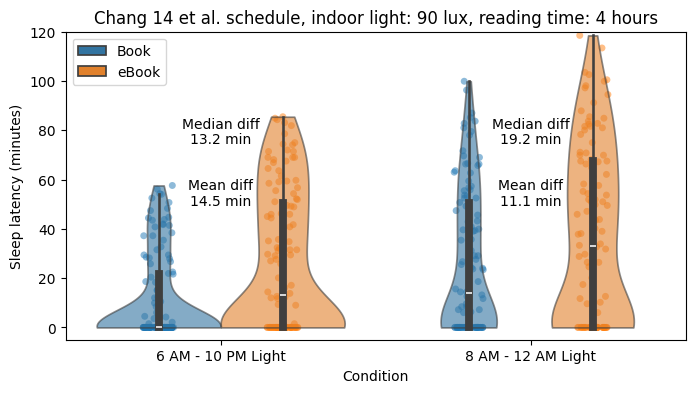

In [97]:
# Sleep latency at last condition day for Chang 14 schedule
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'chang14_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'chang14_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_latency_minutes']

    ebook_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_latency_minutes']

    sub_df = pd.DataFrame({
        'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
        'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
        'light_condition': [light_condition] * (len(book_sleep_latency) + len(ebook_sleep_latency))
    }, index=np.arange(len(book_sleep_latency) + len(ebook_sleep_latency)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_latency',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_latency', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)
# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])

median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_latency'] - median_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_latency'] - median_values.loc[('Book', 'late_light'), 'sleep_latency']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_latency'] - mean_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_latency'] - mean_values.loc[('Book', 'late_light'), 'sleep_latency']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours')
ax.set_ylabel('Sleep latency (minutes)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')
ax.set_ylim(-5, 120)

plt.savefig('figures/chang14_low_indoor_light_sleep_latency_light_conditions.pdf', bbox_inches='tight')
plt.show()

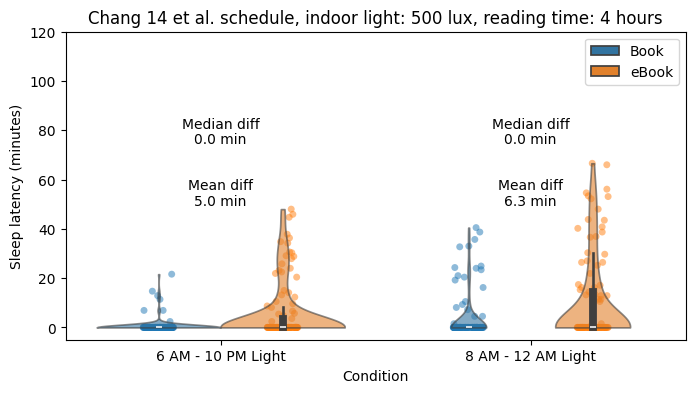

In [98]:
# Sleep latency at last condition day for Chang 14 schedule with high indoor light
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'chang14_high_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'chang14_high_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_latency_minutes']

    ebook_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_latency_minutes']

    sub_df = pd.DataFrame({
        'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
        'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
        'light_condition': [light_condition] * (len(book_sleep_latency) + len(ebook_sleep_latency))
    }, index=np.arange(len(book_sleep_latency) + len(ebook_sleep_latency)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_latency',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_latency', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_latency'] - median_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_latency'] - median_values.loc[('Book', 'late_light'), 'sleep_latency']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_latency'] - mean_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_latency'] - mean_values.loc[('Book', 'late_light'), 'sleep_latency']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours')
ax.set_ylabel('Sleep latency (minutes)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')
ax.set_ylim(-5, 120)

plt.savefig('figures/chang14_high_indoor_light_sleep_latency_light_conditions.pdf', bbox_inches='tight')
plt.show()

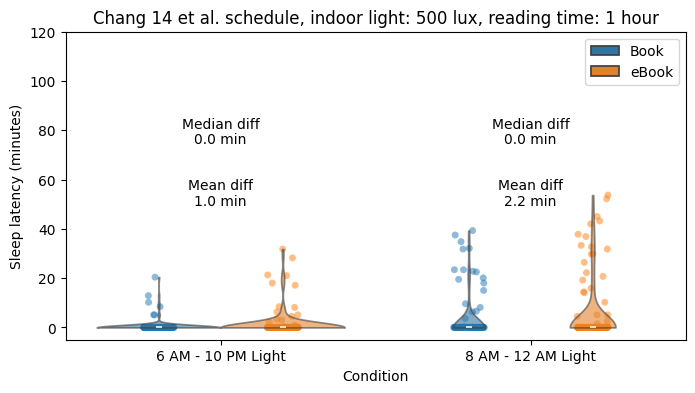

In [99]:
# Sleep latency at last condition day for Chang 14 schedule with realistic reading time
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'realistic_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'realistic_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_latency_minutes']

    ebook_sleep_latency = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_latency_minutes']

    sub_df = pd.DataFrame({
        'sleep_latency': np.concatenate([book_sleep_latency, ebook_sleep_latency]),
        'condition': ['Book'] * len(book_sleep_latency) + ['eBook'] * len(ebook_sleep_latency),
        'light_condition': [light_condition] * (len(book_sleep_latency) + len(ebook_sleep_latency))
    }, index=np.arange(len(book_sleep_latency) + len(ebook_sleep_latency)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_latency',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_latency', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_latency'] - median_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_latency'] - median_values.loc[('Book', 'late_light'), 'sleep_latency']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_latency'] - mean_values.loc[('Book', 'early_light'), 'sleep_latency']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_latency'] - mean_values.loc[('Book', 'late_light'), 'sleep_latency']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour')
ax.set_ylabel('Sleep latency (minutes)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')
ax.set_ylim(-5, 120)

plt.savefig('figures/chang14_realistic_sleep_latency_light_conditions.pdf', bbox_inches='tight')
plt.show()

# Sleep duration

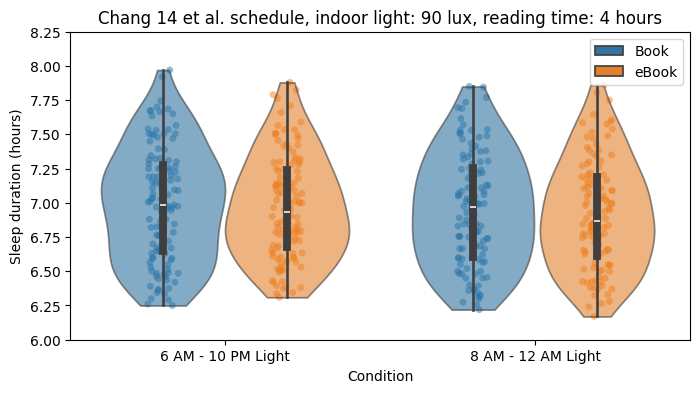

In [100]:
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'chang14_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'chang14_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_duration']

    ebook_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_duration']

    sub_df = pd.DataFrame({
        'sleep_duration': np.concatenate([book_sleep_duration, ebook_sleep_duration]),
        'condition': ['Book'] * len(book_sleep_duration) + ['eBook'] * len(ebook_sleep_duration),
        'light_condition': [light_condition] * (len(book_sleep_duration) + len(ebook_sleep_duration))
    }, index=np.arange(len(book_sleep_duration) + len(ebook_sleep_duration)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_duration',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_duration', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_duration'] - median_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_duration'] - median_values.loc[('Book', 'late_light'), 'sleep_duration']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_duration'] - mean_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_duration'] - mean_values.loc[('Book', 'late_light'), 'sleep_duration']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours')
ax.set_ylabel('Sleep duration (hours)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')

ax.set_ylim(6, 8.25)

plt.savefig('figures/chang14_low_indoor_light_sleep_duration_light_conditions.pdf', bbox_inches='tight')
plt.show()

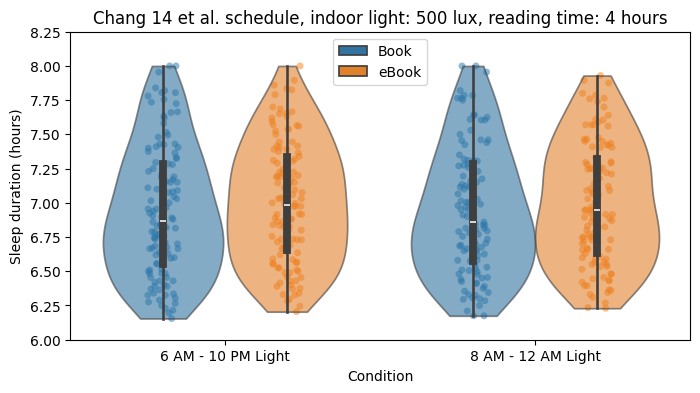

In [101]:
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'chang14_high_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'chang14_high_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_duration']

    ebook_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_duration']

    sub_df = pd.DataFrame({
        'sleep_duration': np.concatenate([book_sleep_duration, ebook_sleep_duration]),
        'condition': ['Book'] * len(book_sleep_duration) + ['eBook'] * len(ebook_sleep_duration),
        'light_condition': [light_condition] * (len(book_sleep_duration) + len(ebook_sleep_duration))
    }, index=np.arange(len(book_sleep_duration) + len(ebook_sleep_duration)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_duration',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_duration', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_duration'] - median_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_duration'] - median_values.loc[('Book', 'late_light'), 'sleep_duration']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_duration'] - mean_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_duration'] - mean_values.loc[('Book', 'late_light'), 'sleep_duration']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours')
ax.set_ylabel('Sleep duration (hours)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')

ax.set_ylim(6, 8.25)

plt.savefig('figures/chang14_high_indoor_light_sleep_duration_light_conditions.pdf', bbox_inches='tight')
plt.show()

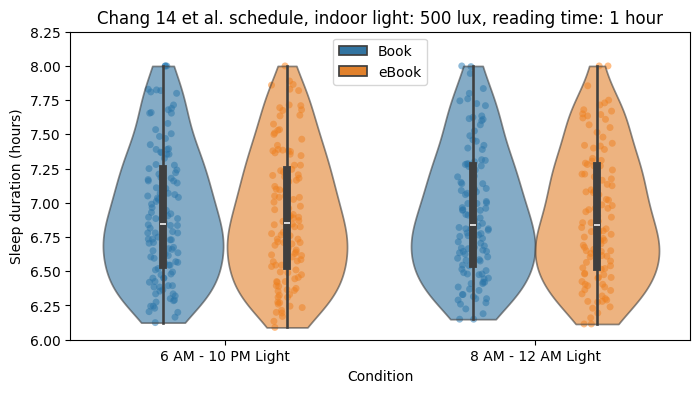

In [102]:
light_condition_options  = ['early_light', 'late_light']
scheduled_bedtime = 22.0
df = pd.DataFrame()

for light_condition in light_condition_options:
    possible_days = (simulation_features['day'] == 6) | (simulation_features['day'] == 12)

    possible_simulation_conditions = ((simulation_features['simulation_condition'] == 'realistic_ebook_first') |  \
                                      (simulation_features['simulation_condition'] == 'realistic_ebook_second') ) & \
                                     (simulation_features['light_condition'] == light_condition)

    book_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'Book') & 
                                             possible_simulation_conditions]['sleep_duration']

    ebook_sleep_duration = simulation_features[possible_days & (simulation_features['daily_condition'] == 'eBook') &
                                              possible_simulation_conditions]['sleep_duration']

    sub_df = pd.DataFrame({
        'sleep_duration': np.concatenate([book_sleep_duration, ebook_sleep_duration]),
        'condition': ['Book'] * len(book_sleep_duration) + ['eBook'] * len(ebook_sleep_duration),
        'light_condition': [light_condition] * (len(book_sleep_duration) + len(ebook_sleep_duration))
    }, index=np.arange(len(book_sleep_duration) + len(ebook_sleep_duration)))

    df = pd.concat([df, sub_df])


fig, ax = plt.subplots(figsize=(8, 4))
palette = {'Book': 'tab:blue', 'eBook': 'tab:orange'}

plotting_parameters = {
    'data': df,
    'x': 'light_condition',
    'y': 'sleep_duration',
    'hue': 'condition',
    'palette': palette,
    'cut': 0,
    'inner': 'box',
}


sns.violinplot(**plotting_parameters, ax=ax)
for violin  in ax.collections[::]:
    violin.set_alpha(0.6)

sns.stripplot(x='light_condition', y='sleep_duration', data=df, ax=ax, dodge=True, hue='condition',
              alpha=0.5, zorder=0, legend=False, palette=palette)

# Change x tick labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])


median_values = df.groupby(['condition', 'light_condition']).median()
early_light_diff = median_values.loc[('eBook', 'early_light'), 'sleep_duration'] - median_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff = median_values.loc[('eBook', 'late_light'), 'sleep_duration'] - median_values.loc[('Book', 'late_light'), 'sleep_duration']
mean_values = df.groupby(['condition', 'light_condition']).mean()
early_light_diff_mean = mean_values.loc[('eBook', 'early_light'), 'sleep_duration'] - mean_values.loc[('Book', 'early_light'), 'sleep_duration']
late_light_diff_mean = mean_values.loc[('eBook', 'late_light'), 'sleep_duration'] - mean_values.loc[('Book', 'late_light'), 'sleep_duration']

ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.25, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.25, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{early_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.25, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.annotate(f'Median diff', xy=(0.5, 0.5), xytext=(0.75, 0.7), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.65), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'Mean diff', xy=(0.5, 0.5), xytext=(0.75, 0.5), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)
ax.annotate(f'{late_light_diff_mean:.1f} min', xy=(0.5, 0.5), xytext=(0.75, 0.45), textcoords='axes fraction',
            fontsize=10, color='black', ha='center', va='center', zorder=1000)


ax.set_title('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour')
ax.set_ylabel('Sleep duration (hours)')
ax.set_xlabel('Condition')
ax.get_legend().set_title('')

ax.set_ylim(6, 8.25)

plt.savefig('figures/chang14_realistic_sleep_duration_light_conditions.pdf', bbox_inches='tight')
plt.show()

# Mean sleep onset evolution

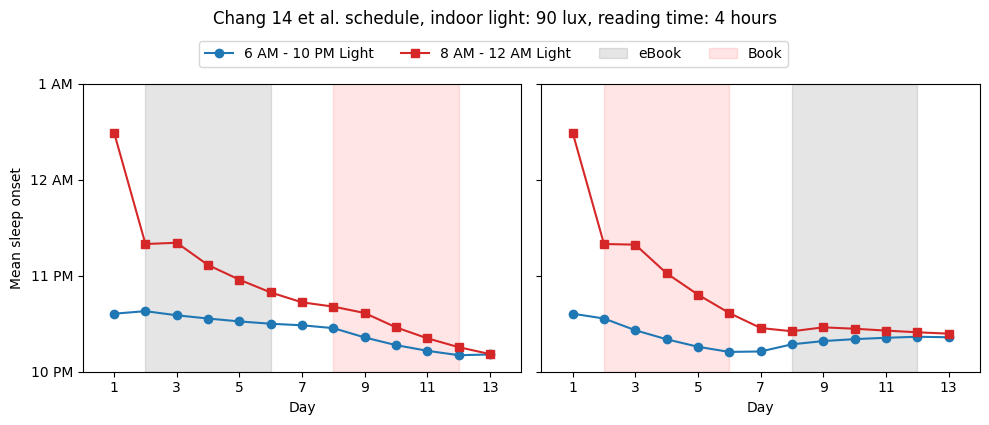

In [103]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_onset = ebook_first.groupby('day')['sleep_onset'].mean() + offset[idx]
    ebook_second_sleep_onset = ebook_second.groupby('day')['sleep_onset'].mean() + offset[idx]

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    axs[0].set_yticks([22, 23, 24, 25])
    axs[0].set_yticklabels(['10 PM', '11 PM', '12 AM', '1 AM'])

    axs[0].set_ylabel('Mean sleep onset')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours',
             y=1.05)

plt.tight_layout()

plt.savefig('figures/chang14_low_indoor_light_sleep_onset_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

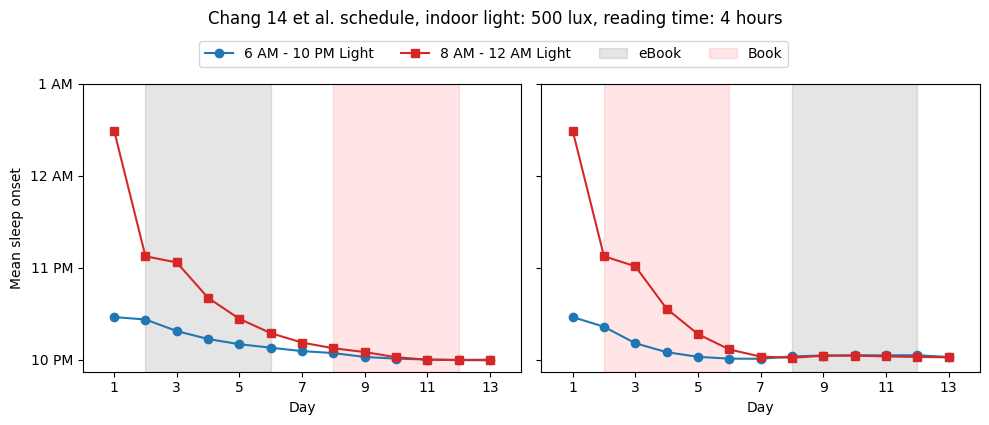

In [104]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_high_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_high_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_onset = ebook_first.groupby('day')['sleep_onset'].mean() + offset[idx]
    ebook_second_sleep_onset = ebook_second.groupby('day')['sleep_onset'].mean() + offset[idx]

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    axs[0].set_yticks([22, 23, 24, 25])
    axs[0].set_yticklabels(['10 PM', '11 PM', '12 AM', '1 AM'])

    axs[0].set_ylabel('Mean sleep onset')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours',
             y=1.05)

plt.tight_layout()

plt.savefig('figures/chang14_high_indoor_light_sleep_onset_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

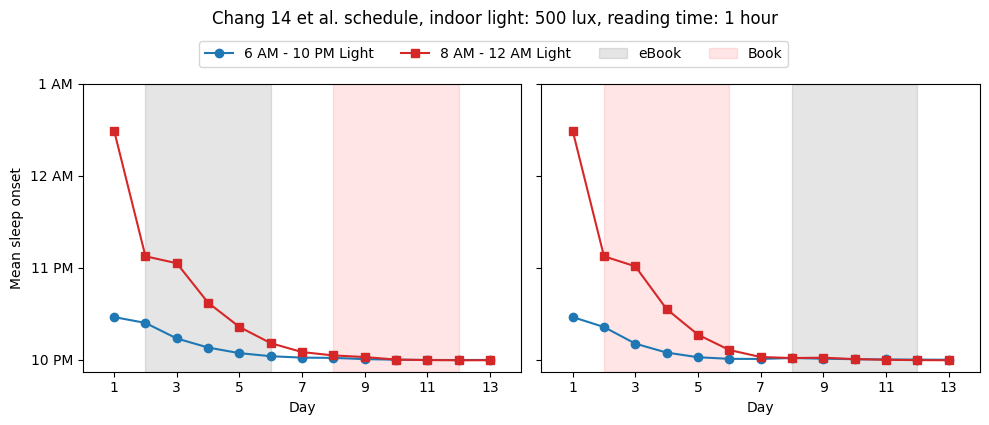

In [105]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'realistic_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'realistic_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_onset = ebook_first.groupby('day')['sleep_onset'].mean() + offset[idx]
    ebook_second_sleep_onset = ebook_second.groupby('day')['sleep_onset'].mean() + offset[idx]

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_onset,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])
    axs[0].set_yticks([22, 23, 24, 25])
    axs[0].set_yticklabels(['10 PM', '11 PM', '12 AM', '1 AM'])

    axs[0].set_ylabel('Mean sleep onset')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour',
             y=1.05)

plt.tight_layout()

plt.savefig('figures/chang14_realistic_sleep_onset_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

# Mean sleep duration evolution

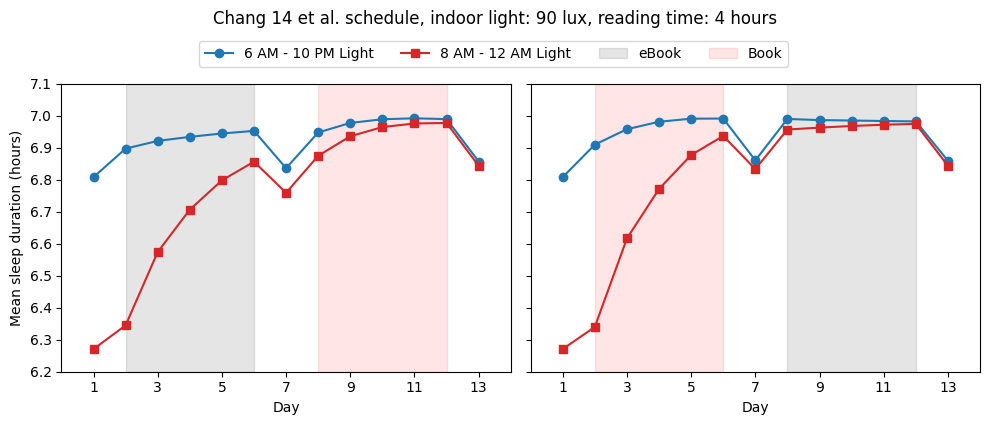

In [112]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_duration = ebook_first.groupby('day')['sleep_duration'].mean()
    ebook_second_sleep_duration = ebook_second.groupby('day')['sleep_duration'].mean()

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])

    axs[0].set_ylabel('Mean sleep duration (hours)')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 90 lux, reading time: 4 hours',
             y=1.05)

axs[0].set_ylim(6.2, 7.1)

plt.tight_layout()

plt.savefig('figures/chang14_low_indoor_light_sleep_duration_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

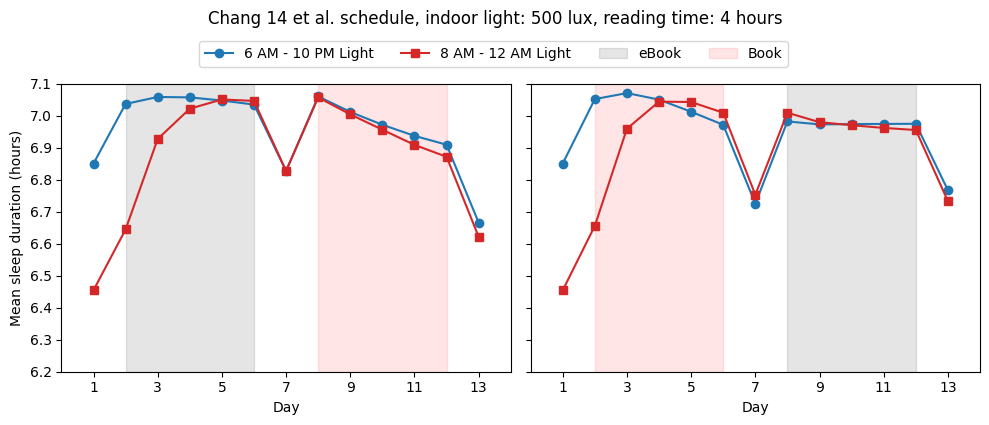

In [113]:

light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'chang14_high_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'chang14_high_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_duration = ebook_first.groupby('day')['sleep_duration'].mean()
    ebook_second_sleep_duration = ebook_second.groupby('day')['sleep_duration'].mean()

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])

    axs[0].set_ylabel('Mean sleep duration (hours)')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 4 hours',
             y=1.05)
axs[0].set_ylim(6.2, 7.1)

plt.tight_layout()

plt.savefig('figures/chang14_high_indoor_light_sleep_duration_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()

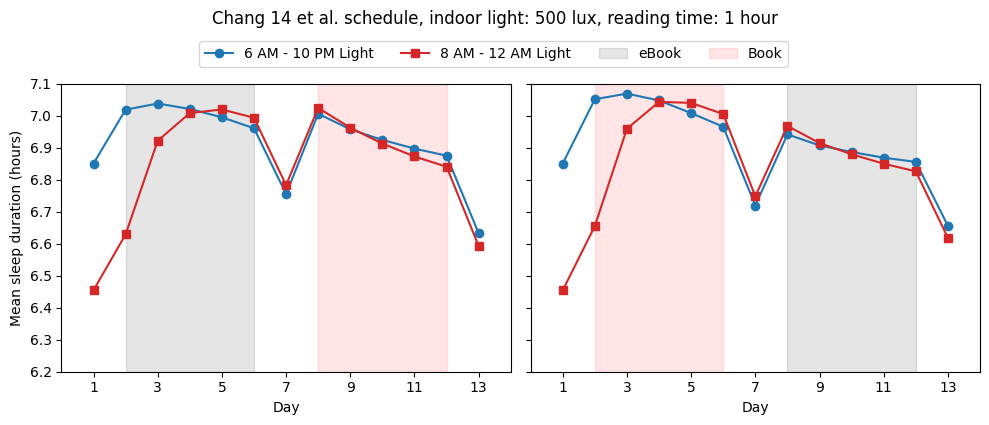

In [114]:
light_condition_options  = ['early_light', 'late_light']
marker_options = ['o', 's']
colors = ['tab:blue', 'tab:red']
labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
offset = [0.0, 24.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for idx, light_condition in enumerate(light_condition_options):
    marker = marker_options[idx]
    ebook_first = simulation_features[(simulation_features['simulation_condition'] == 'realistic_ebook_first') & \
                                      (simulation_features['light_condition'] == light_condition)]
    ebook_second = simulation_features[(simulation_features['simulation_condition'] == 'realistic_ebook_second') & \
                                       (simulation_features['light_condition'] == light_condition)]

    ebook_first_sleep_duration = ebook_first.groupby('day')['sleep_duration'].mean()
    ebook_second_sleep_duration = ebook_second.groupby('day')['sleep_duration'].mean()

    days = np.arange(1, 14)


    axs[0].plot(days, ebook_first_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[1].plot(days, ebook_second_sleep_duration,
                marker=marker, color=colors[idx],
                label=labels[idx])

    axs[0].set_xlim(0, 14)
    axs[1].set_xlim(0, 14)
    axs[0].set_xticks(days[::2])
    axs[1].set_xticks(days[::2])

    axs[0].set_ylabel('Mean sleep duration (hours)')
    axs[0].set_xlabel('Day')
    axs[1].set_xlabel('Day')

axs[0].axvspan(2, 6, color='black', alpha=0.1, label='eBook')
axs[0].axvspan(8, 12, color='red', alpha=0.1, label='Book')
axs[1].axvspan(2, 6, color='red', alpha=0.1)
axs[1].axvspan(8, 12, color='black', alpha=0.1)


# create a legend for square markers and circle markers
handles, labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2], handles[3]]
labels = [labels[0], labels[1], labels[2], labels[3]]
fig.legend(handles, labels, loc='center right',
        bbox_to_anchor=(0.8, 0.94), ncol=4)
fig.subplots_adjust(wspace=0.01)
fig.suptitle('Chang 14 et al. schedule, indoor light: 500 lux, reading time: 1 hour',
             y=1.05)

axs[0].set_ylim(6.2, 7.1)
plt.tight_layout()

plt.savefig('figures/chang14_realistic_sleep_duration_evolution_light_conditions.pdf', bbox_inches='tight')

plt.show()